In [1]:
import sys
sys.path.append("..")
from pathlib import Path
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from statsmodels.nonparametric._kernel_base import gpke, _adjust_shape
from graphstructure.simple_substructure import SubstructureSimple, ConnectionBraces
from graphstructure.sample import SimpleConstraints
import json
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
class MixedKDE():
    def __init__(self) -> None:
        c = SimpleConstraints()
        self.brace_dict = ConnectionBraces.ordered_dict()
        self.N_BRACES = len(self.brace_dict)
        # the real structures are stored outside of the graphstructure package
        # with open(Path(__file__).parent.parent / "util/real_structures.json") as f:
        with open("real_structures.json") as f:
            real = json.load(f)

        self.max_layers = max([d["n_layers"] for d in real])

        encodings_real = [self.encode(d) for d in real]
        X = np.array(encodings_real)

        df = pd.DataFrame(X, columns=self.transformed_columns)
        self.instance_df = pd.DataFrame(columns=self.transformed_columns)
        self.continuous = ["total_height", "radius_bottom", "radius_top"] + ["layer_height{}".format(i) for i in range(self.max_layers-2)]
        self.ordered = ["legs", "n_layers"]
        self.unordered = ["brace{}".format(i) for i in range(self.max_layers-1)] 

        self.var_type = self.get_str_list()
        self.k_vars = len(self.var_type)

        # continuous_idx = [df.columns.get_loc(x) for x in continuous]
        # from sklearn.compose import ColumnTransformer
        # from sklearn.preprocessing import StandardScaler
        # self.ct = ColumnTransformer(
        #     transformers=[("scaler", StandardScaler(), continuous)],
        #     remainder='passthrough',
        # )
        # data_trans = self.ct.fit_transform(df)
        # self.transformed_training_data = data_trans.copy()
        # self.clf = SVC(kernel="linear", C=1, gamma=0.001)
        print("Mixed KDE")
        self.clf = KDEMultivariate(df, self.var_type)
        print(self.clf.__repr__())
        # pdf_values = self.clf.pdf(df)
        # log_likelihoods = np.log(pdf_values)
        # sns.displot(log_likelihoods)
        # self.clf.fit(data_trans)

    def get_str_list(self):
        # Create a list where each character corresponds to a variable type
        result_list = []

        for column in self.transformed_columns:
            if column in self.continuous:
                result_list.append("c")
            elif column in self.ordered:
                result_list.append("o")
            elif column in self.unordered:
                result_list.append("u")
            else:
                # Handle the case where the column doesn't match any type
                result_list.append("?")

        result_string = "".join(result_list)
        return result_string

    # from https://stackoverflow.com/questions/38592324/one-hot-encoding-using-numpy
    def get_one_hot(self, targets, nb_classes):
        res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
        return res.reshape(list(targets.shape)+[nb_classes])
    def encode(self, d, one_hot=False, native=False):
        basics = [d["legs"], d["total_height"], d["radius_bottom"], d["radius_top"], d["n_layers"]]

        # fill design's braces according to max_layers with dummies ("NONE")
        braces = d["connection_types"]
        if native:
            braces = np.array([b for b in braces] + ["NONE"] * (self.max_layers - 1 - len(braces)))
        else:
            braces = np.array([self.brace_dict[b] for b in braces] + [self.brace_dict["NONE"]] * (self.max_layers - 1 - len(braces)))
            if one_hot:
                braces = self.get_one_hot(braces, self.N_BRACES)

        # fill design's layer_heights according to max_layers with dummies
        layer_heights = d["layer_heights"]
        layer_heights = np.array(layer_heights + [d["total_height"]] * (self.max_layers - 2 - len(layer_heights))) / d["total_height"]
        self.transformed_columns = ["legs", "total_height", "radius_bottom", "radius_top", "n_layers"] + ["brace" + str(i) for i in range(len(braces.flatten()))] + ["layer_height" + str(i) for i in range(len(layer_heights))]

        to_return = np.array([*basics, *braces.flatten(), *layer_heights])
        # return a flat encoding

        return to_return

Mixed KDE
KDE instance
Number of variables: k_vars = 14
Number of samples:   nobs = 100
Variable types:      occcouuuuucccc
BW selection method: normal_reference



/tmp/ipykernel_1644737/1654825769.py:39: RuntimeWarning: invalid value encountered in log
  log_likelihoods = np.log(pdf_values)
/home/luser/Kallikrates/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/luser/Kallikrates/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


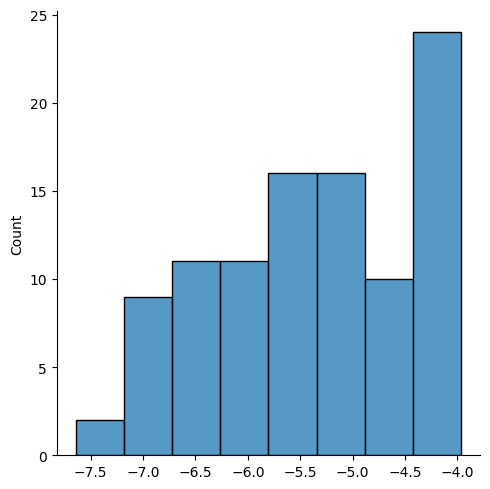

In [5]:
mkde = MixedKDE()